# Using Principal Components Analysis to characterize the structure of population activity



In [1]:
import numpy as np
import os
from datavyz import gen as ge # data visualization module

## Load and pre-process the data

In [2]:
from analysis import load_data_from_folder, from_raw_data_to_deltaFoverF

data_params = {
    'freq_acq' : 30., # Hz
}
preprocessing_params = {
    'fraction_of_substracted_neuropil':0.7, # unitless
    'percentile_threshold_for_baseline': 20, # unitless
    'sliding_window_for_baseline' : 30, # seconds
    'fluo_factor_wrt_neuropil_for_inclusion':1.5, # unitless
}

data_directory = '/home/yann/Downloads/Ca_data/'

folders  = [os.path.join(data_directory, d) for d in os.listdir(data_directory)]
print('Data available in the directory: "%s"' % data_directory)
for i, f in enumerate(os.listdir(data_directory)):
    print('%i) %s' % (i+1, f))

data, Data = from_raw_data_to_deltaFoverF(folders[0], **preprocessing_params, **data_params,
                                          verbose=True)

Data available in the directory: "/home/yann/Downloads/Ca_data/"
1) TSeries-061119_58-0087-002
2) TSeries-061119_58-0001-001
 data from: "/home/yann/Downloads/Ca_data/TSeries-061119_58-0087-002" succesfully loaded 
----> Pre-processing the fluorescence of n=173 ROIs across n=9074 time samples
 1) [...] applying the ROI selection and the neuropil criteria
----> n=10 ROIs are considered as valid cells
 2) [...] substracting neuropil contamination
 3) [...] calculating sliding baseline per cell
 4) [...] performing DeltaF/F normalization
----> Pre-processing done !


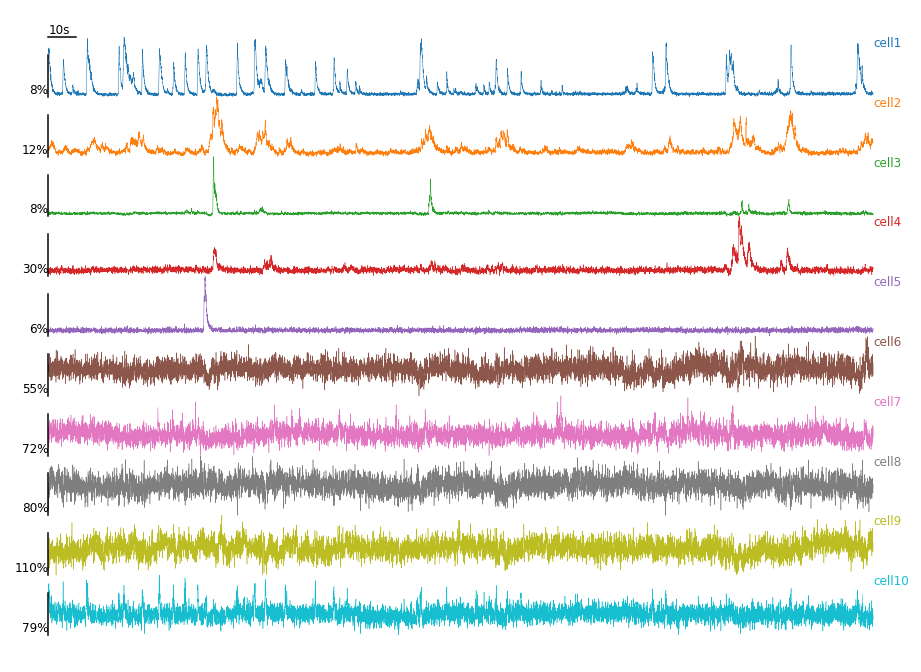

In [3]:
ge.Ca_trace_plot(Data, Tbar=10, t=data['t']);

## Performing PCA

using scikit-learn, see:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [4]:
from sklearn.decomposition import PCA as sklPCA

def PCA(data,
        n_components=2, desired_var_explained=None):

    if desired_var_explained is not None:
        pca = sklPCA(n_components=desired_var_explained)
    else:
        pca = sklPCA(n_components=n_components)

    X = np.array([data[key] for key in data]).T # insuring shape (n_samples, n_features)
    pca.fit(X) 

    return pca


# run PCA
pca = PCA(data['norm_Data'], n_components = len(Data)) # desired_var_explained=0.9)       
X = np.array([data['norm_Data'][key] for key in Data]).T # insuring shape (n_samples, n_features)


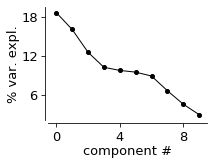

In [5]:
# let's plot the variance explained by the components
ge.plot(100.*pca.explained_variance_ratio_,
        m='o', ms=4, xlabel='component #', ylabel='% var. expl.');

## Visualizing the comodulation pattern corresponding to the first PCA component

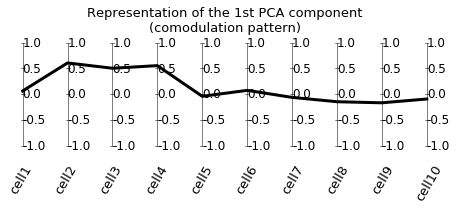

In [21]:
# -> visualizing the comodulation pattern corresponding to a component


fig, ax = ge.parallel_plot(pca.components_[0:1],
                 #SET_OF_LIMS=[[pca.components_[:,i].min(), pca.components_[:,i].max()] for i in range(len(Data))],
                 SET_OF_LIMS=[[-1, 1] for i in range(len(Data))],
                 SET_OF_LABELS=list(Data.keys()), lw=3,
                 tick_number = 5, tick_size=0.01, 
                 fig_args=dict(bottom=.5, left=.5, right=2.),
                 label_annotation_args=dict(va='top', ha='center',rotation=60.));
ge.title(ax, 'Representation of the 1st PCA component\n(comodulation pattern)')

## Analyzing the activity captured by the 1st PCA component

In [17]:
# How to see the output of the first component ?

pca1 = PCA(data['norm_Data'], n_components = 1) # we restrict the PCA to the first component
X = np.array([data['norm_Data'][key] for key in Data]).T # insuring shape (n_samples, n_features)
X1_new = pca1.fit_transform(X) # we perform the projection on the PCA dimension
X1 = pca1.inverse_transform(X1_new) # we inverse transform to get it back to the original (Neuron, samples) space
pc1_Data = {}
for i, key in enumerate(Data):
    pc1_Data[key] = X1[:,i]*data['std_Data'][key]+data['mean_Data'][key]


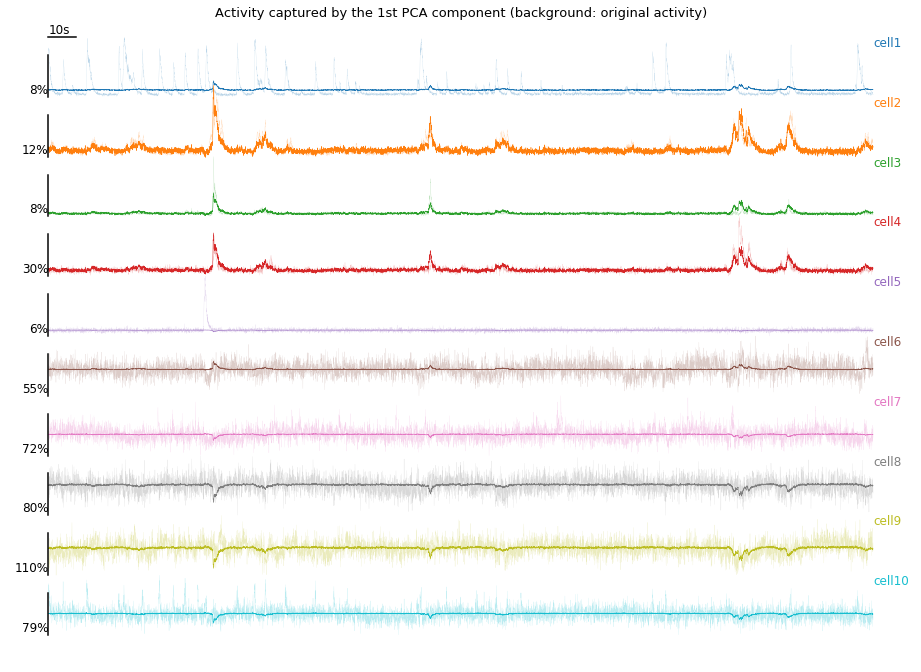

In [18]:
ge.Ca_trace_plot(pc1_Data, Data_original=Data, t=data['t'],
                 title='Activity captured by the 1st PCA component (background: original activity)');

## Analyzing the second component

In [19]:
# see the output of the second component
pca2 = PCA(data['norm_Data'], n_components = 2)
X = np.array([data['norm_Data'][key] for key in Data]).T # insuring shape (n_samples, n_features)
X_new = pca2.fit_transform(X)
X2 = pca2.inverse_transform(X_new)
pc2_Data = {}
for i, key in enumerate(Data):
    pc2_Data[key] = (X2[:,i]-X1[:,i])*data['std_Data'][key]+data['mean_Data'][key]


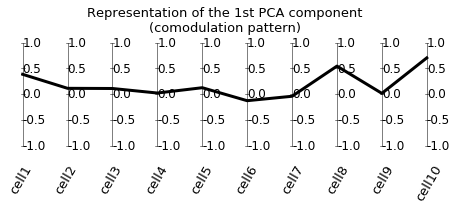

In [22]:
fig, ax = ge.parallel_plot(pca.components_[1:2],
                 SET_OF_LIMS=[[-1, 1] for i in range(len(Data))],
                 SET_OF_LABELS=list(Data.keys()), lw=3,
                 tick_number = 5, tick_size=0.01, 
                 fig_args=dict(bottom=.5, left=.5, right=2.),
                 label_annotation_args=dict(va='top', ha='center',rotation=60.));
ge.title(ax, 'Representation of the 1st PCA component\n(comodulation pattern)')

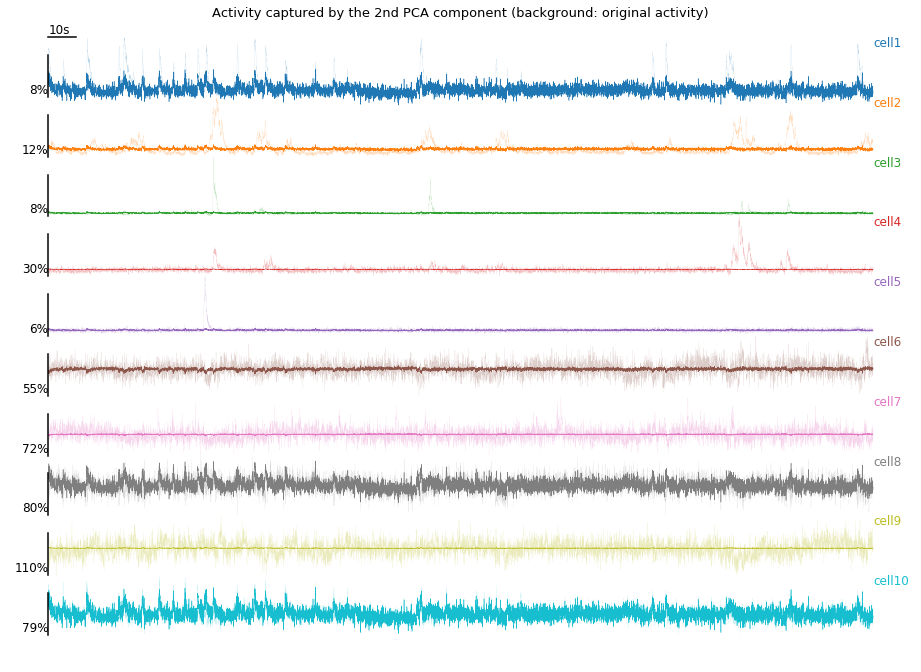

In [24]:
ge.Ca_trace_plot(pc2_Data, Data_original=Data, t=data['t'],
                 title='Activity captured by the 2nd PCA component (background: original activity)');